# Example 2: Mean Risk Optimisation with Linear Asset Weight Constraints

## 1. Download data.

In [1]:
using PortfolioOptimiser, TimeSeries, DataFrames, PrettyTables, Clarabel, HiGHS, YFinance,
      GraphRecipes, StatsPlots, JuMP

# Format for pretty tables.
fmt1 = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
fmt2 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

# Convert prices to time array.
function stock_price_to_time_array(x)
    # Only get the keys that are not ticker or datetime.
    coln = collect(keys(x))[3:end]
    # Convert the dictionary into a matrix.
    m = hcat([x[k] for k ∈ coln]...)
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end

# Asset tickers.
assets = sort!(["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA", "COST", "CSCO",
                "GILD", "GOOG", "GOOGL", "HON", "ISRG", "LIN", "MAR", "META", "MRK", "MSFT",
                "NFLX", "NVDA", "ORLY", "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN",
                "VRTX"])

# Prices date range.
Date_0 = "2019-01-01"
Date_1 = "2025-01-31"

# Download the price data using YFinance.
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets))
pretty_table(prices[1:5]; formatters = fmt1)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     ADI │     ADP │    AMGN │    AMZN │    BKNG │   CMCSA │    COST │    CSCO │    GILD │    GOOG │   GOOGL │     HON │    ISRG │     LIN │     MAR │    META │     MRK │    MSFT │    NFLX │    NVDA │    ORLY │    PANW │    QCOM │    SBUX │       T │    TMUS │    TSLA │     TXN │    VRTX │
│   DateTime │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─

## 2. Estimating Mean Risk Portfolios

### 2.1. Optimising portfolio

This is a simple example so we will only use default parameters for computing the statistics.

For API details and options available see: `Portfolio`, `PortOptSolver`, `PortfolioOptimiser.MeanEstimator`, `PortfolioOptimiser.PortfolioOptimiserCovCor`, `asset_statistics!`, `RiskMeasure`, `PortfolioOptimiser.ObjectiveFunction`, `PortfolioOptimiser.OptimType`.

In [2]:
# Creating the portfolio object. Internally computes the returns if you give a prices TimeArray.
port = Portfolio(; prices = prices,
                 # Continuous solvers.
                 solvers = PortOptSolver(; name = :Clarabel, solver = Clarabel.Optimizer,
                                         params = Dict("verbose" => false)),
                 # Discrete solvers (for discrete allocation).
                 alloc_solvers = PortOptSolver(; name = :HiGHS,
                                               solver = optimizer_with_attributes(HiGHS.Optimizer,
                                                                                  MOI.Silent() => true)))

# Compute relevant statistics.
# Expected returns and covariance estimation methods.
mu_type = MuSimple()
cov_type = PortCovCor()

# Only compute `mu` and `cov`.
asset_statistics!(port; mu_type = mu_type, cov_type = cov_type, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
# Creating the optimisation object.
rm = Variance() # Risk measure.
obj = MinRisk() # Objective function. Can be `MinRisk()`, `Utility()`, `Sharpe()`, `MaxRet()`.
# `Trad` optimisation corresponds to the classic mean risk optimisation.
type = Trad(; rm = rm, obj = obj)

# Optimise portfolio.
w1 = optimise!(port, type)
pretty_table(w1; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    0.0 % │
│     ADI │    0.0 % │
│     ADP │    0.0 % │
│    AMGN │  3.904 % │
│    AMZN │  1.772 % │
│    BKNG │    0.0 % │
│   CMCSA │  1.107 % │
│    COST │ 20.146 % │
│    CSCO │    0.0 % │
│    GILD │ 15.179 % │
│    GOOG │    0.0 % │
│   GOOGL │    0.0 % │
│     HON │  0.789 % │
│    ISRG │    0.0 % │
│     LIN │  1.811 % │
│     MAR │  3.442 % │
│    META │    0.0 % │
│     MRK │  23.13 % │
│    MSFT │    0.0 % │
│    NFLX │  0.399 % │
│    NVDA │    0.0 % │
│    ORLY │  6.399 % │
│    PANW │   3.04 % │
│    QCOM │    0.0 % │
│    SBUX │    0.0 % │
│       T │ 13.093 % │
│    TMUS │   5.79 % │
│    TSLA │    0.0 % │
│     TXN │    0.0 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


### 2.2. Plotting portfolio composition.

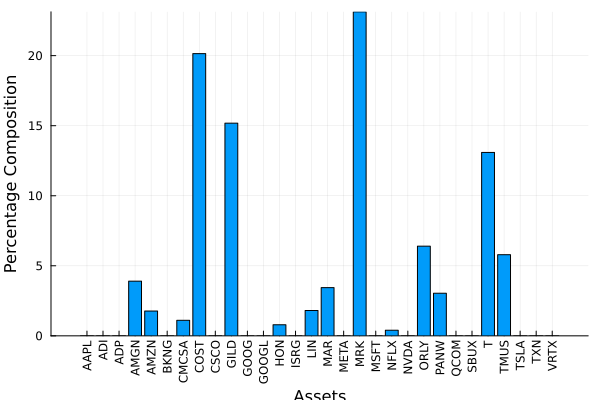

In [3]:
plot_bar(port)

## 3. Asset and asset set constraints

### 3.1. Creating the constraints

The function `asset_constraints` takes in two dataframes, one defining the asset sets, and another defining the constraints and turns them into a matrix and vector which sets the constraints as $\\mathbf{A} \\bm{x} >= \\bm{b}$.

In [4]:
asset_sets = DataFrame(;
                       Asset = ["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA",
                                "COST", "CSCO", "GILD", "GOOG", "GOOGL", "HON", "ISRG",
                                "LIN", "MAR", "META", "MRK", "MSFT", "NFLX", "NVDA", "ORLY",
                                "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN", "VRTX"],
                       Sector = ["Technology", "Technology", "Technology", "Health Care",
                                 "Consumer Discretionary", "Consumer Discretionary",
                                 "Telecommunications", "Consumer Discretionary",
                                 "Telecommunications", "Health Care", "Technology",
                                 "Technology", "Industrials", "Health Care", "Industrials",
                                 "Consumer Discretionary", "Technology", "Health Care",
                                 "Technology", "Consumer Discretionary", "Technology",
                                 "Consumer Discretionary", "Technology", "Technology",
                                 "Consumer Discretionary", "Telecommunications",
                                 "Telecommunications", "Consumer Discretionary",
                                 "Technology", "Health Care"],
                       Industry = ["Computer Manufacturing", "Semiconductors",
                                   "EDP Services",
                                   "Biotechnology: Biological Products (No Diagnostic Substances)",
                                   "Catalog/Specialty Distribution",
                                   "Transportation Services",
                                   "Cable & Other Pay Television Services",
                                   "Department/Specialty Retail Stores",
                                   "Computer Communications Equipment",
                                   "Biotechnology: Biological Products (No Diagnostic Substances)",
                                   "Computer Software: Programming Data Processing",
                                   "Computer Software: Programming Data Processing",
                                   "Aerospace", "Industrial Specialties", "Major Chemicals",
                                   "Hotels/Resorts",
                                   "Computer Software: Programming Data Processing",
                                   "Biotechnology: Pharmaceutical Preparations",
                                   "Computer Software: Prepackaged Software",
                                   "Consumer Electronics/Video Chains", "Semiconductors",
                                   "Auto & Home Supply Stores",
                                   "Computer peripheral equipment",
                                   "Radio And Television Broadcasting And Communications Equipment",
                                   "Restaurants", "Telecommunications Equipment",
                                   "Telecommunications Equipment", "Auto Manufacturing",
                                   "Semiconductors",
                                   "Biotechnology: Pharmaceutical Preparations"])
pretty_table(asset_sets)

┌────────┬────────────────────────┬────────────────────────────────────────────────────────────────┐
│  Asset │                 Sector │                                                       Industry │
│ String │                 String │                                                         String │
├────────┼────────────────────────┼────────────────────────────────────────────────────────────────┤
│   AAPL │             Technology │                                         Computer Manufacturing │
│    ADI │             Technology │                                                 Semiconductors │
│    ADP │             Technology │                                                   EDP Services │
│   AMGN │            Health Care │  Biotechnology: Biological Products (No Diagnostic Substances) │
│   AMZN │ Consumer Discretionary │                                 Catalog/Specialty Distribution │
│   BKNG │ Consumer Discretionary │                                        Transportation S

We will create different sets of constraints because it makes demonstrations easier.

It's also worth noting that constraints may make problems infeasable, for example constraining all `N` assets to have weights greater than `1/(N-1)`, or it may be impossible to simultaneously satisfy multiple constraints, for example constraining all assets to have weights greater than or equal to 0.1, and requiring one asset to have a weight smaller than or equal to 0.05.

Constrain individual assets.

In [5]:
constraints_1 = DataFrame(; Enabled = [true, true, true, true, true, true],
                          Type = ["Asset", "Asset", "Asset", "Asset", "Asset", "Asset"],
                          Set = ["", "", "", "", "", ""],
                          Position = ["COST", "AAPL", "ADP", "T", "GILD", "GOOG"],
                          Sign = ["<=", ">=", "<=", ">=", "<=", ">="],
                          Weight = [0.13, 0.04, "", "", "", ""],
                          Relative_Type = ["", "", "Asset", "Asset", "Subset", "Subset"],
                          Relative_Set = ["", "", "", "", "Sector", "Industry"],
                          Relative_Position = ["", "", "MAR", "MRK", "Telecommunications",
                                               "Telecommunications Equipment"],
                          Factor = ["", "", 2, 0.7, 0.3, 1])
pretty_table(constraints_1)

┌─────────┬────────┬────────┬──────────┬────────┬────────┬───────────────┬──────────────┬──────────────────────────────┬────────┐
│ Enabled │   Type │    Set │ Position │   Sign │ Weight │ Relative_Type │ Relative_Set │            Relative_Position │ Factor │
│    Bool │ String │ String │   String │ String │    Any │        String │       String │                       String │    Any │
├─────────┼────────┼────────┼──────────┼────────┼────────┼───────────────┼──────────────┼──────────────────────────────┼────────┤
│    true │  Asset │        │     COST │     <= │   0.13 │               │              │                              │        │
│    true │  Asset │        │     AAPL │     >= │   0.04 │               │              │                              │        │
│    true │  Asset │        │      ADP │     <= │        │         Asset │              │                          MAR │      2 │
│    true │  Asset │        │        T │     >= │        │         Asset │              │ 

Create linear constraint matrix and vector and optimise with these constraints.

In [6]:
A1, B1 = asset_constraints(constraints_1, asset_sets)

# Clear the arrays because the code asserts the dimensions.
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A1
port.b_ineq = B1

w2 = optimise!(port, type)
pretty_table(w2; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    4.0 % │
│     ADI │    0.0 % │
│     ADP │    0.0 % │
│    AMGN │  9.448 % │
│    AMZN │    0.0 % │
│    BKNG │    0.0 % │
│   CMCSA │  5.515 % │
│    COST │   13.0 % │
│    CSCO │  1.091 % │
│    GILD │  5.992 % │
│    GOOG │ 13.368 % │
│   GOOGL │    0.0 % │
│     HON │  0.037 % │
│    ISRG │    0.0 % │
│     LIN │  3.183 % │
│     MAR │  0.816 % │
│    META │    0.0 % │
│     MRK │ 19.097 % │
│    MSFT │    0.0 % │
│    NFLX │    0.0 % │
│    NVDA │    0.0 % │
│    ORLY │  9.213 % │
│    PANW │  1.852 % │
│    QCOM │    0.0 % │
│    SBUX │    0.0 % │
│       T │ 13.368 % │
│    TMUS │    0.0 % │
│    TSLA │    0.0 % │
│     TXN │    0.0 % │
│    VRTX │   0.02 % │
└─────────┴──────────┘


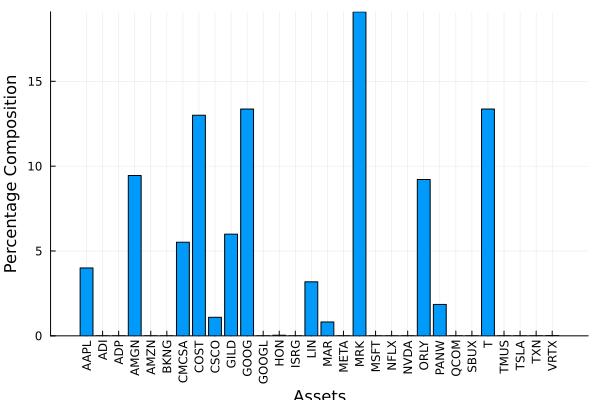

In [7]:
plot_bar(port)

Constrain all assets.

In [8]:
constraints_2 = DataFrame(; Enabled = [true, true, true, true, true, true],
                          Type = ["All Assets", "All Assets", "All Assets", "All Assets",
                                  "All Assets", "All Assets"],
                          Set = ["", "", "", "", "", ""],
                          Position = ["", "", "", "", "", ""],
                          Sign = [">=", "<=", ">=", "<=", ">=", "<="],
                          Weight = [0.01, 0.2, "", "", "", ""],
                          Relative_Type = ["", "", "Subset", "Subset", "Asset", "Asset"],
                          Relative_Set = ["", "", "Sector", "Industry", "", ""],
                          Relative_Position = ["", "", "Consumer Discretionary",
                                               "Biotechnology: Pharmaceutical Preparations",
                                               "TMUS", "META"],
                          Factor = ["", "", 0.1, 2.1, 0.5, 1.3])
pretty_table(constraints_2)

┌─────────┬────────────┬────────┬──────────┬────────┬────────┬───────────────┬──────────────┬────────────────────────────────────────────┬────────┐
│ Enabled │       Type │    Set │ Position │   Sign │ Weight │ Relative_Type │ Relative_Set │                          Relative_Position │ Factor │
│    Bool │     String │ String │   String │ String │    Any │        String │       String │                                     String │    Any │
├─────────┼────────────┼────────┼──────────┼────────┼────────┼───────────────┼──────────────┼────────────────────────────────────────────┼────────┤
│    true │ All Assets │        │          │     >= │   0.01 │               │              │                                            │        │
│    true │ All Assets │        │          │     <= │    0.2 │               │              │                                            │        │
│    true │ All Assets │        │          │     >= │        │        Subset │       Sector │                   

Create linear constraint matrix and vector and optimise with these constraints.

In [9]:
A2, B2 = asset_constraints(constraints_2, asset_sets)
# Clear the arrays because the code asserts the dimensions.
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A2
port.b_ineq = B2

w3 = optimise!(port, type)
pretty_table(w3; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    1.0 % │
│     ADI │    1.0 % │
│     ADP │    1.0 % │
│    AMGN │ 13.336 % │
│    AMZN │    1.0 % │
│    BKNG │    1.0 % │
│   CMCSA │  2.003 % │
│    COST │  2.999 % │
│    CSCO │    1.0 % │
│    GILD │ 13.338 % │
│    GOOG │    1.0 % │
│   GOOGL │    1.0 % │
│     HON │  3.879 % │
│    ISRG │    1.0 % │
│     LIN │  5.024 % │
│     MAR │    1.0 % │
│    META │  10.26 % │
│     MRK │ 13.338 % │
│    MSFT │    1.0 % │
│    NFLX │    1.0 % │
│    NVDA │    1.0 % │
│    ORLY │    1.0 % │
│    PANW │  1.484 % │
│    QCOM │    1.0 % │
│    SBUX │    1.0 % │
│       T │ 13.338 % │
│    TMUS │    2.0 % │
│    TSLA │    1.0 % │
│     TXN │    1.0 % │
│    VRTX │    1.0 % │
└─────────┴──────────┘


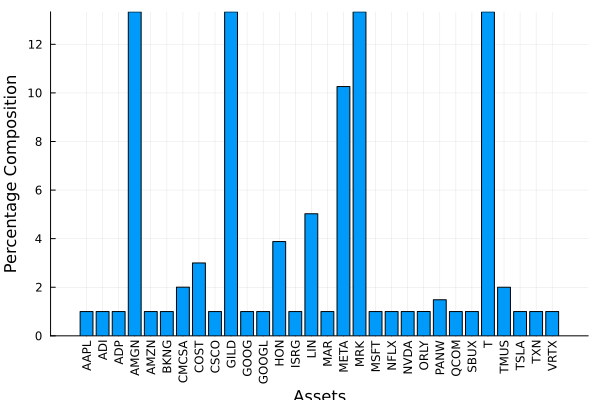

In [10]:
plot_bar(port)

Constrain asset sets.

In [11]:
constraints_3 = DataFrame(; Enabled = [true, true, true, true, true, true],
                          Type = ["Subset", "Subset", "Subset", "Subset", "Subset",
                                  "Subset"],
                          Set = ["Sector", "Sector", "Sector", "Industry", "Industry",
                                 "Industry"],
                          Position = ["Technology", "Consumer Discretionary", "Health Care",
                                      "Semiconductors",
                                      "Biotechnology: Pharmaceutical Preparations",
                                      "Biotechnology: Biological Products (No Diagnostic Substances)"],
                          Sign = [">=", "<=", "<=", ">=", "<=", ">="],
                          Weight = [0.13, 0.25, "", "", "", ""],
                          Relative_Type = ["", "", "Asset", "Asset", "Subset", "Subset"],
                          Relative_Set = ["", "", "", "", "Sector", "Industry"],
                          Relative_Position = ["", "", "MAR", "MRK", "Telecommunications",
                                               "Telecommunications Equipment"],
                          Factor = ["", "", 2, 0.7, 0.1, 0.3])
pretty_table(constraints_3)

┌─────────┬────────┬──────────┬───────────────────────────────────────────────────────────────┬────────┬────────┬───────────────┬──────────────┬──────────────────────────────┬────────┐
│ Enabled │   Type │      Set │                                                      Position │   Sign │ Weight │ Relative_Type │ Relative_Set │            Relative_Position │ Factor │
│    Bool │ String │   String │                                                        String │ String │    Any │        String │       String │                       String │    Any │
├─────────┼────────┼──────────┼───────────────────────────────────────────────────────────────┼────────┼────────┼───────────────┼──────────────┼──────────────────────────────┼────────┤
│    true │ Subset │   Sector │                                                    Technology │     >= │   0.13 │               │              │                              │        │
│    true │ Subset │   Sector │                                        Cons

Create linear constraint matrix and vector and optimise with these constraints.

In [12]:
A3, B3 = asset_constraints(constraints_3, asset_sets)

# Clear the arrays because the code asserts the dimensions.
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A3
port.b_ineq = B3

w4 = optimise!(port, type)
pretty_table(w4; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    0.0 % │
│     ADI │    0.0 % │
│     ADP │  1.603 % │
│    AMGN │  2.208 % │
│    AMZN │    0.0 % │
│    BKNG │    0.0 % │
│   CMCSA │  1.863 % │
│    COST │ 13.861 % │
│    CSCO │  1.783 % │
│    GILD │ 13.492 % │
│    GOOG │  3.886 % │
│   GOOGL │  0.001 % │
│     HON │    0.0 % │
│    ISRG │    0.0 % │
│     LIN │  7.195 % │
│     MAR │  9.627 % │
│    META │    0.0 % │
│     MRK │  3.555 % │
│    MSFT │  0.015 % │
│    NFLX │    0.0 % │
│    NVDA │    0.0 % │
│    ORLY │  1.511 % │
│    PANW │  5.005 % │
│    QCOM │    0.0 % │
│    SBUX │    0.0 % │
│       T │ 21.068 % │
│    TMUS │ 10.834 % │
│    TSLA │    0.0 % │
│     TXN │  2.488 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


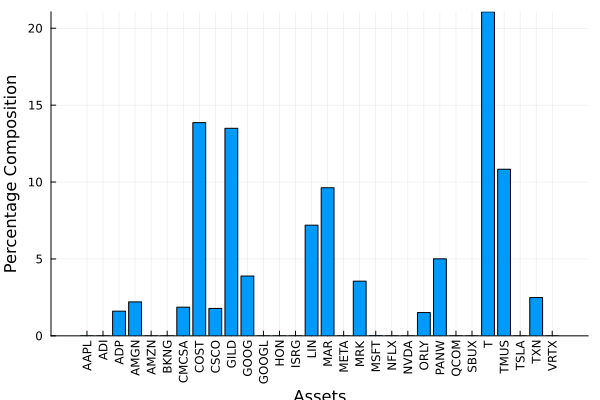

In [13]:
plot_bar(port)

Constrain all asset subsets.

In [14]:
constraints_4 = DataFrame(; Enabled = [true, true, true],
                          Type = ["All Subsets", "All Subsets", "All Subsets"],
                          Set = ["Industry", "Industry", "Sector"], Position = ["", "", ""],
                          Sign = [">=", ">=", "<="], Weight = [0.01, "", ""],
                          Relative_Type = ["", "Asset", "Subset"],
                          Relative_Set = ["", "", "Industry"],
                          Relative_Position = ["", "T", "Semiconductors"],
                          Factor = ["", 0.7, 1.3])
pretty_table(constraints_4)

┌─────────┬─────────────┬──────────┬──────────┬────────┬────────┬───────────────┬──────────────┬───────────────────┬────────┐
│ Enabled │        Type │      Set │ Position │   Sign │ Weight │ Relative_Type │ Relative_Set │ Relative_Position │ Factor │
│    Bool │      String │   String │   String │ String │    Any │        String │       String │            String │    Any │
├─────────┼─────────────┼──────────┼──────────┼────────┼────────┼───────────────┼──────────────┼───────────────────┼────────┤
│    true │ All Subsets │ Industry │          │     >= │   0.01 │               │              │                   │        │
│    true │ All Subsets │ Industry │          │     >= │        │         Asset │              │                 T │    0.7 │
│    true │ All Subsets │   Sector │          │     <= │        │        Subset │     Industry │    Semiconductors │    1.3 │
└─────────┴─────────────┴──────────┴──────────┴────────┴────────┴───────────────┴──────────────┴───────────────────┴──

Create linear constraint matrix and vector and optimise with these constraints.

In [15]:
A4, B4 = asset_constraints(constraints_4, asset_sets)

# Clear the arrays because the code asserts the dimensions.
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A4
port.b_ineq = B4

w5 = optimise!(port, type)
pretty_table(w5; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    1.0 % │
│     ADI │    0.0 % │
│     ADP │    1.0 % │
│    AMGN │    0.0 % │
│    AMZN │    1.0 % │
│    BKNG │    1.0 % │
│   CMCSA │   3.78 % │
│    COST │ 13.561 % │
│    CSCO │    1.0 % │
│    GILD │  7.883 % │
│    GOOG │  0.999 % │
│   GOOGL │    0.0 % │
│     HON │  2.955 % │
│    ISRG │    1.0 % │
│     LIN │  2.073 % │
│     MAR │    1.0 % │
│    META │    0.0 % │
│     MRK │ 17.117 % │
│    MSFT │    1.0 % │
│    NFLX │    1.0 % │
│    NVDA │    0.0 % │
│    ORLY │  6.439 % │
│    PANW │    1.0 % │
│    QCOM │    1.0 % │
│    SBUX │    1.0 % │
│       T │  1.428 % │
│    TMUS │ 10.762 % │
│    TSLA │    1.0 % │
│     TXN │   20.0 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


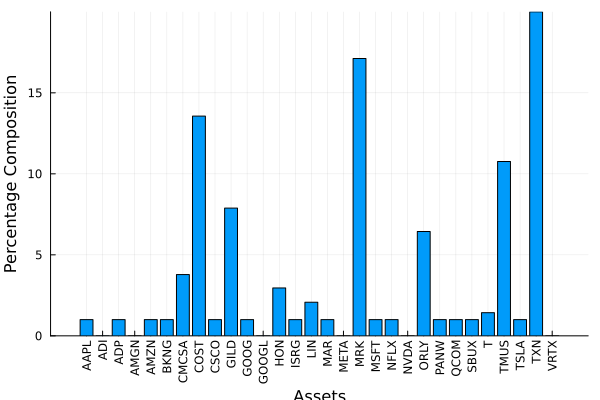

In [16]:
plot_bar(port)

Constrain each asset in subset.

In [17]:
constraints_5 = DataFrame(; Enabled = [true, true, true],
                          Type = ["Each Asset in Subset", "Each Asset in Subset",
                                  "Each Asset in Subset"],
                          Set = ["Sector", "Industry", "Sector"],
                          Position = ["Telecommunications",
                                      "Biotechnology: Biological Products (No Diagnostic Substances)",
                                      "Consumer Discretionary"], Sign = [">=", ">=", "<="],
                          Weight = [0.03, "", ""], Relative_Type = ["", "Asset", "Subset"],
                          Relative_Set = ["", "", "Industry"],
                          Relative_Position = ["", "T", "Semiconductors"],
                          Factor = ["", 0.7, 1.3])
pretty_table(constraints_5)

┌─────────┬──────────────────────┬──────────┬───────────────────────────────────────────────────────────────┬────────┬────────┬───────────────┬──────────────┬───────────────────┬────────┐
│ Enabled │                 Type │      Set │                                                      Position │   Sign │ Weight │ Relative_Type │ Relative_Set │ Relative_Position │ Factor │
│    Bool │               String │   String │                                                        String │ String │    Any │        String │       String │            String │    Any │
├─────────┼──────────────────────┼──────────┼───────────────────────────────────────────────────────────────┼────────┼────────┼───────────────┼──────────────┼───────────────────┼────────┤
│    true │ Each Asset in Subset │   Sector │                                            Telecommunications │     >= │   0.03 │               │              │                   │        │
│    true │ Each Asset in Subset │ Industry │ Biotechnology:

Create linear constraint matrix and vector and optimise with these constraints.

In [18]:
A5, B5 = asset_constraints(constraints_5, asset_sets)

# Clear the arrays because the code asserts the dimensions.
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A5
port.b_ineq = B5

w6 = optimise!(port, type)
pretty_table(w6; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    0.0 % │
│     ADI │  0.014 % │
│     ADP │    0.0 % │
│    AMGN │  7.405 % │
│    AMZN │  2.874 % │
│    BKNG │    0.0 % │
│   CMCSA │    3.0 % │
│    COST │  6.638 % │
│    CSCO │    3.0 % │
│    GILD │ 14.822 % │
│    GOOG │  0.001 % │
│   GOOGL │    0.0 % │
│     HON │  0.499 % │
│    ISRG │    0.0 % │
│     LIN │  2.085 % │
│     MAR │  2.395 % │
│    META │    0.0 % │
│     MRK │ 24.232 % │
│    MSFT │    0.0 % │
│    NFLX │  0.506 % │
│    NVDA │    0.0 % │
│    ORLY │  6.638 % │
│    PANW │  3.296 % │
│    QCOM │    0.0 % │
│    SBUX │    0.0 % │
│       T │ 10.578 % │
│    TMUS │  6.922 % │
│    TSLA │    0.0 % │
│     TXN │  5.093 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


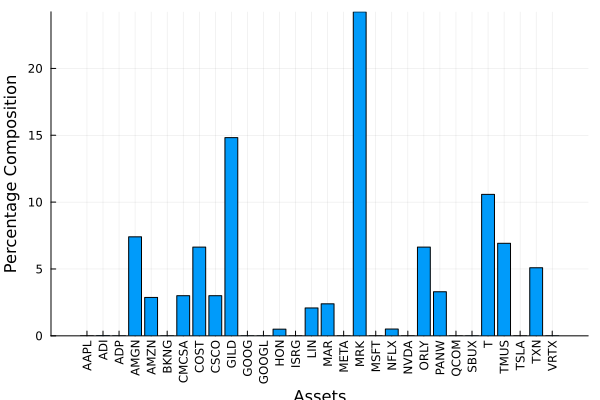

In [19]:
plot_bar(port)

## 4. Efficient Frontier

It's possible to compute the efficient frontier with constraints. It will be different to the vanilla one in the previous tutorial because the constraints will be applied to every optimisation.

In [20]:
port.a_ineq = Matrix(undef, 0, 0)
port.b_ineq = Vector(undef, 0)
port.a_ineq = A2
port.b_ineq = B2

points = 50
frontier = efficient_frontier!(port, type; points = 50)
pretty_table(frontier[:weights]; formatters = fmt2)

┌─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬──────────┐
│ tickers │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │       9 │       10 │       11 │       12 │       13 │       14 │       15 │       16 │       17 │       18 │       19 │       20 │       21 │       22 │       23 │       24 │       25 │       26 │       27 │       28 │       29 │       30 │       31 │       32 │       33 │       34 │       35 │       36 │       37 │       38 │ 

Plot frontier.

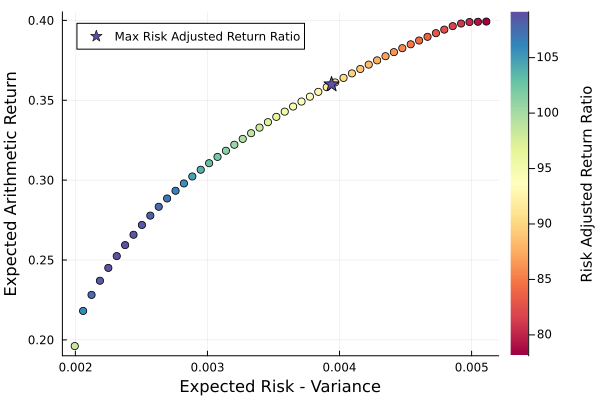

In [21]:
plot_frontier(port; rm = rm)

Plot frontier area.

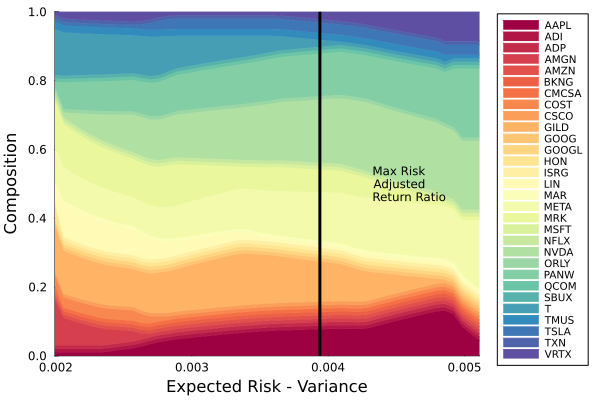

In [22]:
plot_frontier_area(port; rm = rm, kwargs_a = (; legendfontsize = 7))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*